In [4]:
%%capture capt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import pickle

### Dictionnaires de GridSearch pour les meilleurs paramètres de chaque fonction

In [5]:
with open('../data/grid_search/gridSearch.pickle', 'rb') as handle:
    grid_search = pickle.load(handle)
print(len(grid_search))

4199


In [3]:
with open('../data/grid_search/gridSearch_norm.pickle', 'rb') as handle:
    grid_search_norm = pickle.load(handle)
print(len(grid_search_norm))

4226


In [4]:
with open('../data/grid_search/gridSearch_scaled.pickle', 'rb') as handle:
    grid_search_scaled = pickle.load(handle)
print(len(grid_search_scaled))

4646


In [5]:
with open('../data/grid_search/gridSearch_filter.pickle', 'rb') as handle:
    grid_search_filter = pickle.load(handle)
print(len(grid_search_filter))

4584


In [6]:
with open('../data/grid_search/gridSearch_filter_4weights.pickle', 'rb') as handle:
    grid_search_filter_4w = pickle.load(handle)
print(len(grid_search_filter_4w))

122


In [7]:
def get_nb_clusters_from_key(key):
    return int(key.split(',')[0].split(':')[-1])

def get_meilleurs_params(dic, max_clusters=None):
    max_score = -float('inf')
    max_key = ''
    if not max_clusters:
        max_clusters = float('inf')
        
    for key in dic.keys():
        if dic[key] >= max_score and get_nb_clusters_from_key(key) <= max_clusters:
            max_score, max_key = dic[key], key
    return max_score, max_key

In [8]:
best_params_norm = get_meilleurs_params(grid_search_norm)
print(f"Meilleurs params normalise --> {best_params_norm}")

Meilleurs params normalise --> (0.058388449763529505, 'n_clusters:33, weights:50 5 1')


In [9]:
best_params = get_meilleurs_params(grid_search)
print(f"Meilleurs params non normalise --> {best_params}")

Meilleurs params non normalise --> (0.05881224330601615, 'n_clusters:5, weights:50 50 5')


In [10]:
best_params_scaled = get_meilleurs_params(grid_search_scaled)
print(f"Meilleurs params scaled --> {best_params_scaled}")

Meilleurs params scaled --> (0.9684855479335592, 'n_clusters:39, weights:45 10 1')


In [11]:
best_params_filter = get_meilleurs_params(grid_search_filter)
print(f"Meilleurs params filter --> {best_params_filter}")

Meilleurs params filter --> (1.8567908109912595e-05, 'n_clusters:5, weights:100 60 45')


In [12]:
def score_fct_clusters(dic, title):
    range_max_clusters = range(5, 42)
    best_params_scaled = [get_meilleurs_params(dic, max_clusters=max_clusters)[0] for max_clusters in range_max_clusters]
    plt.plot(range_max_clusters, best_params_scaled)
    plt.title(f"Max score clusters en fonction du nombre max de clusters autorisés\n{title}")
    plt.xlabel("Nb clusters max autorisé")
    plt.show()

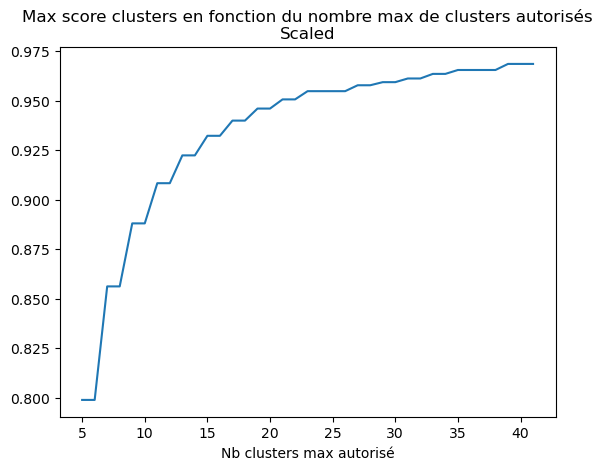

In [13]:
score_fct_clusters(grid_search_scaled, 'Scaled')

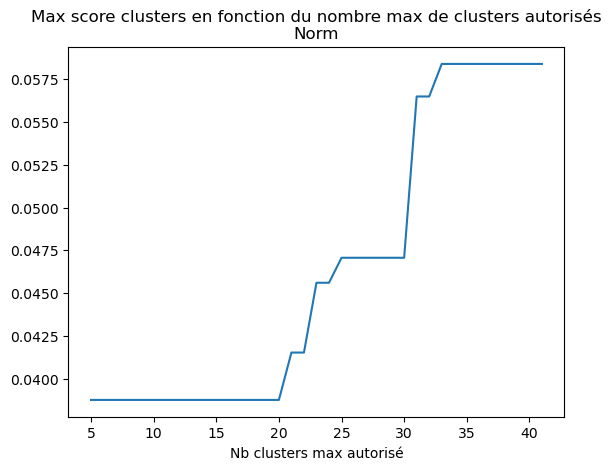

In [14]:
score_fct_clusters(grid_search_norm, 'Norm')

### Meilleur par nombre de clusters

In [15]:
def get_best_params_fixed_n_clusters(dic, n_clusters):
    max_score = -float('inf')
    max_key = ''
    for key in dic.keys():
        if dic[key] >= max_score and get_nb_clusters_from_key(key) == n_clusters:
            max_score, max_key = dic[key], key
    return max_score, max_key

In [16]:
def score_by_n_clusters(dic, title):
    range_clusters = range(5, 32, 2)
    best_params = [get_best_params_fixed_n_clusters(dic, n_clusters)[0] for n_clusters in range_clusters]
    plt.plot(range_clusters, best_params)
    plt.title(f"Max score clusters en fonction du nombre de clusters\n{title}")
    plt.xlabel("Nb clusters")
    plt.show()

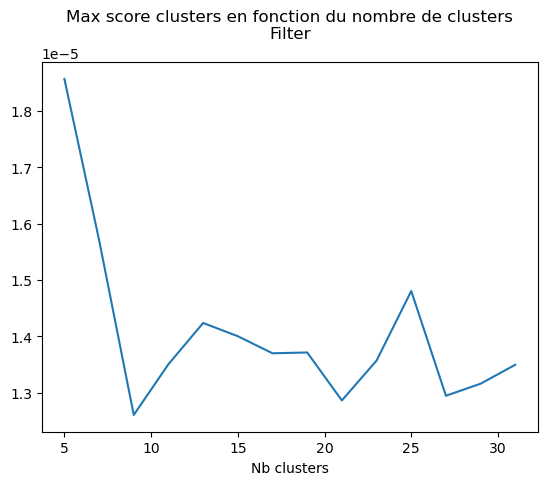

In [17]:
score_by_n_clusters(grid_search_filter, 'Filter')

### Clustering pour chacun des meilleurs params

In [18]:
%run Calculate_clusters.ipynb

Installation/Importation des librairies necessaires.
CPU cores available -> 72


In [19]:
def get_weights_from_params(params):
    key = params[1].split(',')[-1].split(':')[-1].split(' ')
    weights_params = [int(weight) for weight in key]
    return weights_params

In [20]:
import warnings
warnings.filterwarnings("ignore")

#### Custom scaled

In [ ]:
max_clusters = 21
best_params_scaled_max_clusters = get_meilleurs_params(grid_search_scaled, max_clusters=max_clusters)
print(best_params_scaled_max_clusters)

In [ ]:
kmedoids_scaled_max_clusters, base_scaled_max_clusters = base_finale(X_patient, 'custom', scaled=True, 
                                                 weights_metric=get_weights_from_params(best_params_scaled_max_clusters), 
                                                 n_clusters = get_nb_clusters_from_key(best_params_scaled_max_clusters[-1]))

In [ ]:
base_scaled_max_clusters.to_csv('../data/grid_search/scaled.csv', index=False)
medoid_indices = kmedoids_scaled_max_clusters.medoid_indices_
with open('../data/grid_search/scaled_medoids.npy', 'wb') as f:
    np.save(f, medoid_indices)

#### Custom norm

In [ ]:
max_clusters = 25

In [ ]:
best_params_norm = get_meilleurs_params(grid_search_norm, 25)
print(best_params_norm)

In [ ]:
kmedoids_norm, base_norm = base_finale(X_patient, 'custom_norm', scaled=False, 
                                       weights_metric=get_weights_from_params(best_params_norm), 
                                       n_clusters = get_nb_clusters_from_key(best_params_norm[-1]))

In [ ]:
base_norm.to_csv('../data/grid_search/norm_25.csv', index=False)
medoid_indices = kmedoids_norm.medoid_indices_
with open('../data/grid_search/norm_medoids_25.npy', 'wb') as f:
    np.save(f, medoid_indices)

#### Custom

In [ ]:
best_params = get_meilleurs_params(grid_search)
print(best_params)

In [ ]:
kmedoids_std, base_std = base_finale(X_patient, 'custom', scaled=False, 
                                     weights_metric=get_weights_from_params(best_params), 
                                     n_clusters = get_nb_clusters_from_key(best_params[-1]))

### Filter

In [ ]:
best_params_filter = get_best_params_fixed_n_clusters(grid_search_filter, 5)
print(best_params_filter)

In [ ]:
weights_filter = get_weights_from_params(best_params_filter)
n_clusters_filter = get_nb_clusters_from_key(best_params_filter[-1])
print('weights ->', weights_filter, '//  n_cluster ->', n_clusters_filter)

In [23]:
kmedoids_filter, base_filter = base_finale(X_patient, 'filter_dist', scaled=True, 
                                     weights_metric=get_weights_from_params(best_params_filter), 
                                     n_clusters = get_nb_clusters_from_key(best_params_filter[-1]))

Calcul des distances, weights=[35, 20, 10]
Distances calculees en 479s, calcul des clusters -> n_clusters=5


In [ ]:
for i in range(1, get_nb_clusters_from_key(best_params_filter[-1])+1):
    print(base_filter[f'cluster{i}'].sum())

In [28]:
def save_file(kmedoids, base, method, weights, n_clusters):
    base.to_csv(f'../data/grid_search/{method}_{weights[0]}_{weights[1]}_{weights[2]}__{n_clusters}.csv', index=False)
    print(f'save base as ../data/grid_search/{method}_{weights[0]}_{weights[1]}_{weights[2]}__{n_clusters}.csv')
    medoids_indices = kmedoids.medoid_indices_
    with open(f'../data/grid_search/medoids_{method}_{weights[0]}_{weights[1]}_{weights[2]}__{n_clusters}.npy', 'wb') as f:
        np.save(f, medoid_indices)
    print(f'save medoids as ../data/grid_search/medoids_{method}_{weights[0]}_{weights[1]}_{weights[2]}__{n_clusters}.npy')

### Filter - 4 weights

##### In this dictionary, we don't have the score by clusters, so we have to find the best number or clusters for the best weights

In [21]:
def weights_from_string(weights):
    w = weights.split(' ')
    for i in range(len(w)):
        w[i] = int(w[i])
    return w

In [22]:
best_weights = None
max_score = 0
for key in grid_search_filter_4w.keys():
    if grid_search_filter_4w[key] > max_score:
        max_score = grid_search_filter_4w[key]
        best_weights = key
best_weights = weights_from_string(best_weights)
print(best_weights, '->', max_score)

[55, 30, 20, 1] -> 1.9150348545543208e-05
